# Online Shopper Segmentation
I will use the newly available **online_retail_ii.xlsx** dataset available at the UCI repository: https://archive.ics.uci.edu/dataset/502/online+retail+ii.

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Fields available:
- ***InvoiceNo***: Invoice number.A 6-digit integral number is uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- ***StockCode***: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- ***Description***: Product (item) name. Nominal.
- ***Quantity***: The quantities of each product (item) per transaction. Numeric.
- ***InvoiceDate***: Invoice date and time. Numeric. The day and time when a transaction was generated.
- ***UnitPrice***: Unit price. Numeric. Product price per unit in sterling (Â£).
- ***CustomerID***: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- ***Country***: Country name. Nominal. The name of the country where a customer resides.

In [ ]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Load the data
This is an Excel file, so we need to use the `pd.read_excel` reader. Also, the data is divided into two worksheet, so we need to specify those as they follow the same format.

In previous versions of Pandas it was possible to specify the sheets to load; however, I had to resort to the article at https://stackoverflow.com/questions/73950804/is-there-a-simpler-way-to-read-multiple-sheets-of-an-excel-workbook-into-a-singl to find this neat solution.

In [ ]:
df_all = pd.read_excel('./online_retail_II.xlsx', sheet_name=None, index_col=None, header=0)
for k, v in df_all.items():
    v['Year'] = k

df = pd.concat(df_all, ignore_index=True).dropna()
print('# of records', len(df))

# of records 824364


Close to a mil records. It will make some operations a little bit slower, but plenty of data to work with.

In [ ]:
df.head()

# 2. Aggregate at the Customer Level
To conduct an RFM analysis we need to create an aggregate based on customers as that is the level of aggregate we will be working with. We will assume that a customer will come from the same country. Meaning, we do not have a customer ID coming from two different countries.

## 2.1 Creating the ***Total*** column
Because the data does not contain the value of a purchase, we need to create a ***Total*** column which is: **Total=Price*Quantity***.

**NOTE:** Remmber this is expressed in pounds.

In [ ]:
df['Total']=df['Quantity']*df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Year 2009-2010,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Year 2009-2010,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Year 2009-2010,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Year 2009-2010,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Year 2009-2010,30.0


## 2.2 Dealing with the Date for Recency
Recency is ordered differently from Frequency and Monetary: the most recent purchase is the most important. So we need to ensure this is what we are measuring.

### 2.2.1 Checking the `InvoiceDate` type.

In [ ]:
df['InvoiceDate']

The `InvoiceDate` is a DateTime object

The `InvoiceDate` column looks good as it is a DateTime object.

### 2.2.2 Calculate the most recent date of purchase
Let's calculate the beginning of the period.

Because this represent the most recent purchase, we will add one day to this date so that when we calculate the number of days from the most recent purchase, the record with the most recent purchase will result, as a purchase that took place in the last day instead of in the last zero days. Not a big deal, but it is more elegant.

In [ ]:
most_recent_purchase = df['InvoiceDate'].max() + timedelta(days = 1)
print('Most recent purchase:', most_recent_purchase)

Most recent purchase: 2011-12-10 12:50:00


## 2.3 Aggregate at the customer Level
We want to aggregate the customers, identified by Customer ID, by their recency.

To do this, we will calculate the number of days elapsed from the most recent purchase (already identified by `most_recent_purchase`).

In [ ]:
df_agg = df.groupby(['Customer ID'], as_index=False).agg({'InvoiceDate': lambda x: (most_recent_purchase-x.max()).days, 'Invoice': 'count', 'Total': 'sum'})
df_agg.rename(columns={'InvoiceDate':'Recency', 'Invoice':'Frequency','Total':'Monetary'}, inplace=True)
df_agg.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,48,-64.68
1,12347.0,2,253,5633.32
2,12348.0,75,51,2019.40
3,12349.0,19,180,4404.54
4,12350.0,310,17,334.40


Sometimes for Monetary, you can calculate the average value of an invoice instead of its total value.

**Pros**:

  - **Sensitivity to Product Mix**:

     The average invoice value is sensitive to the mix of products purchased and can help in understanding purchasing patterns, especially in businesses with a wide range of product prices. It can highlight customers who buy more expensive items, even if they buy fewer items.

  - **Reduced Skewness**:
    
     Total invoice value can be highly skewed with few very high values, making the average a better representative of the central tendency of the monetary value. The use of other means like the trimmed mean, which removes the top and bottom k%, might be even better.
    
  - **Better Differentiation:**
     
     In some cases, it can provide better differentiation between customers, especially in scenarios where customers buy a similar number of items but with varying item prices.

**Cons**:

  - **Loss of Information**:
    
     Using average invoice value loses information about the total value and frequency, especially important for businesses where total spend is more important than the price of individual items.

  - **Reduced Sensitivity to Volume**:
  
     The average value is less sensitive to the volume of products bought, which can be a disadvantage if buying in bulk is a significant part of customer behavior.

  - **Not Suitable for Every Business Model**:

     For businesses selling homogeneous products or where bulk purchasing is the norm, the total invoice value may be more insightful.

**Decision Criteria**:

- If the business aims to understand customer preferences regarding the types or prices of products they usually buy, the average invoice value may be more relevant.

- If the business is more focused on the total revenue or profit from each customer, regardless of the types or prices of the products they buy, the total invoice value would be more appropriate.

**Examples**

  - **High-Value Item Purchase**:
       If a customer buys one high-value item per invoice, their average and total will be the same, highlighting their preference for high-value items.
  - **Low-Value Bulk Purchase**:
       If another customer buys many low-value items, their total may be similar, but the average will be much lower, distinguishing their bulk purchasing behavior.

For demonstration, I am reporting the line of code to average out the monetary value field.

In [ ]:
df_agg['Moneteraty_AVG'] = df_agg.Monetary/df_agg.Frequency
df_agg.head()

,Customer ID,Recency,Frequency,Monetary,Moneteraty_AVG
0,12346.0,326,48,-64.68,-1.347500
1,12347.0,2,253,5633.32,22.266087
2,12348.0,75,51,2019.40,39.596078
3,12349.0,19,180,4404.54,24.469667
4,12350.0,310,17,334.40,19.670588


# 2.3.1 Apply the Period of Interest
As you saw in the learning module, you want to apply the RFM analysis using a meaningful period of time: 3 months, 6 months, etc.

In [ ]:
# Six months worth of data
period_in_days = 180

print('# of records before:', len(df_agg))
df_agg = df_agg[df_agg['Recency'] <= period_in_days]
print('# of records after:', len(df_agg))

# of records before: 5942
# of records after: 3508


# 3. Generating the Quintiles & Associate Scores
You so that a trick to generate the proper segmentations is to create the quintiles of the dimensions generated. We will then use the quintiles to award the proper score according to the quintile bracket.

## 3.1 Generating Recency Score

In [ ]:
df_agg['R'] = pd.qcut(x=df_agg['Recency'], q=5, labels = range(5, 0, -1))
df_agg.R

1       5
2       2
3       4
6       3
10      4
       ..
5931    2
5932    2
5936    5
5937    5
5941    3
Name: R, Length: 3508, dtype: category
Categories (5, int64): [5 < 4 < 3 < 2 < 1]

## 3.3 Generating Frequency Score

In [ ]:
df_agg['F'] = pd.qcut(x=df_agg['Frequency'], q=5, labels = range(1, 6))
df_agg.F

1       4
2       2
3       4
6       3
10      4
       ..
5931    3
5932    1
5936    1
5937    5
5941    4
Name: F, Length: 3508, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

## 3.3 Generating Monetary Score

In [ ]:
df_agg['M'] = pd.qcut(x=df_agg['Monetary'], q=5, labels = range(1, 6))
df_agg.M

1       5
2       3
3       5
6       3
10      5
       ..
5931    3
5932    1
5936    1
5937    4
5941    4
Name: M, Length: 3508, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [ ]:
df_agg.head()

**NOTE:** Use the Monetary Average in case that is a better variable to track the monetary dimension according to the previous note.

# 4. Calculating RFM Score

In this example I will use the Additive method, which is the most common one.

In [ ]:
# The axis=1 in the sum, indicates that we want to sum the fields by column
df_agg['RFM'] = df_agg[['R', 'F', 'M']].sum(axis=1)
df_agg.head()

,Customer ID,Recency,Frequency,Monetary,Moneteraty_AVG,R,F,M,RFM
1,12347.0,2,253,5633.32,22.266087,5,4,5,14
2,12348.0,75,51,2019.40,39.596078,2,2,3,7
3,12349.0,19,180,4404.54,24.469667,4,4,5,13
6,12352.0,36,113,1889.21,16.718673,3,3,3,9
10,12356.0,23,143,6373.68,44.571189,4,4,5,13


# 5. Segmentation
With the RFM score in place, we can simply define a function that returns the appropriate segment according to the segmentation strategy saw in the learning module.

**NOTE:** That segmentation was done for explanation purposes only. The table should be adapted to the specific analysis and business context.

In [ ]:
def get_RFM_Segment(rfm_score):

  if rfm_score > 13:
    return 'Champion'
  elif rfm_score > 10:
    return 'Loyal'
  elif rfm_score > 6:
    return 'Potential'
  else:
    return 'Need Attention'

df_agg['Segment']=df_agg['RFM'].apply(get_RFM_Segment)
df_agg.head()

# 6. Display the Segmentation & Generating Summaries

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")

# Prepare data
segment_counts = df_agg['Segment'].value_counts()

# Plot
fig, ax = plt.subplots()
ax.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Customer Segmentation')
plt.show()

In [ ]:
pd.set_option('display.precision', 2)
df_agg.groupby('Segment').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']})

# 7. Describing Your Segments
One of the more important step is to elaborate and describe the segments and provide an high level strategy on what to do next.

# Segmentation Results
##1. Champion (425 Customers)

    Recency_average: 7.35
    Frequency_average: 740.49
    Monetary_average: £18,716.38

### Description

Champions are your best customers who have purchased most recently, most often, and are high spenders. With an average monetary value of £18,716.38, this segment is the highest spending and most frequent segment, although it is not the largest in count.

### Points of Interest:

Focus on maintaining relationships and loyalty with this group as they are the most valuable customers.

Offering exclusive deals, previews, or loyalty programs would be effective strategies.
    Understanding their preferences and behaviors will help in personalizing offerings and communications.

## 2. Loyal (819 Customers)

    Recency_average: 26.56
    Frequency_average: 278.29
    Monetary_average: £4,866.99

### Description:
Loyal customers have a decent purchasing frequency and spend reasonably, but their recency is not as high as Champions. They still present a consistent and reliable source of revenue.

### Points of Interest:

Retention strategies are crucial for this segment to prevent churn.

Engagement initiatives like newsletters, updates, and satisfaction surveys can be beneficial.

Upselling and cross-selling can also be effective, given their loyalty.

## 3. Need Attention (960 Customers)

    Recency_average: 82.47
    Frequency_average: 29.99
    Monetary_average: £526.97

### Description:

Customers that need attention have the lowest frequency and monetary value, and they haven’t made purchases recently compared to other segments. They are at risk of churning and may require re-engagement strategies.

### Points of Interest:

Re-engagement strategies, such as personalized offers and communications, can bring them back.

Understanding their needs and preferences can help in creating targeted campaigns.

They are the largest segment in count, thus representing a substantial potential revenue source if re-engaged effectively.

## 4. Potential (1304 Customers)

    Recency_average: 49.69
    Frequency_average: 100.99
    Monetary_average: $1,724.20

### Description:
Potential customers have made purchases more recently than the 'Need Attention' segment and have higher frequency and monetary values. They have the potential to become either Loyal or even Champion if nurtured properly.

### Points of Interest:

Developing relationships with this segment can move them up to a more loyal or champion status.

Monitoring their behavior and preferences can help in creating personalized experiences and offers.

They are the largest segment, thus representing a significant opportunity to increase revenue through proper engagement and personalized marketing strategies.

# Overall Strategy:

## High Value:
Champions and Loyal segments are high-value segments, and the focus should be on retention and maximization strategies like upselling, cross-selling, and loyalty programs.

## Development:
The Potential segment requires developmental strategies like personalized engagement and relationship building to move them to higher value segments.

## Re-engagement and Attraction:
The 'Need Attention' segment needs re-engagement strategies like discounts, offers, and personalized communication to attract them back to making purchases.

# BONUS
We will perform the segmentation using the clustering algorithm kMeans as an alternate way to create customer segments in case a clear business segmentation is not available.

**NOTE:** Because this is a ***Descriptive*** and ***Exploratory*** analytical task, you don't need to split the dataset into training and testing as there is no supervised downstream analysis.

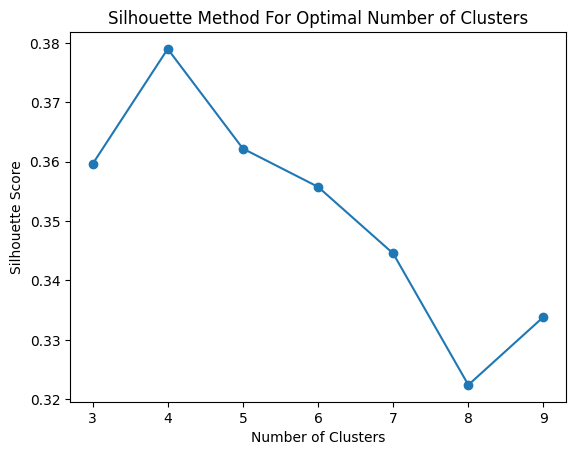

The optimal number of clusters is: 4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


      Customer ID  Recency  Frequency  Monetary  Moneteraty_AVG  R  F  M  RFM  \
1         12347.0        2        253   5633.32       22.266087  5  4  5   14   
2         12348.0       75         51   2019.40       39.596078  2  2  3    7   
3         12349.0       19        180   4404.54       24.469667  4  4  5   13   
6         12352.0       36        113   1889.21       16.718673  3  3  3    9   
10        12356.0       23        143   6373.68       44.571189  4  4  5   13   
...           ...      ...        ...       ...             ... .. .. ..  ...   
5931      18277.0       58         68   1111.38       16.343824  2  3  3    8   
5932      18278.0       74         24    414.20       17.258333  2  1  1    4   
5936      18282.0        8         13    176.60       13.584615  5  1  1    7   
5937      18283.0        4        986   2736.65        2.775507  5  5  4   14   
5941      18287.0       43        156   4177.89       26.781346  3  4  4   11   

      Segment  
1          

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Selecting the features to include in the model
X = df_agg[['R', 'F', 'M']]

# Finding the optimal number of clusters
silhouette_scores = []
cluster_range = range(3, 10)  # Adjust range as needed

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose the number of clusters (k) where the silhouette score is the maximum
optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f'The optimal number of clusters is: {optimal_clusters}')

# Perform k-means clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=10)
df_agg['Segment'] = kmeans.fit_predict(X)

# View the resultant DataFrame
print(df_agg)


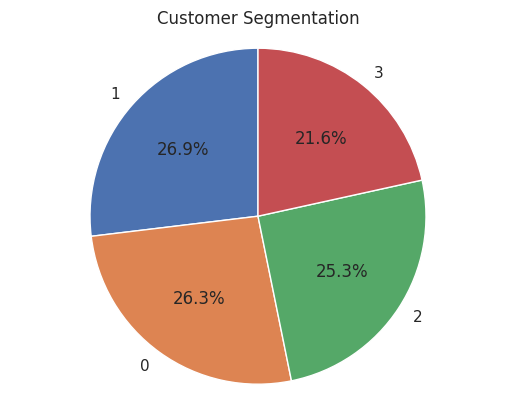

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")

# Prepare data
segment_counts = df_agg['Segment'].value_counts()

# Plot
fig, ax = plt.subplots()
ax.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Customer Segmentation')
plt.show()

You can describe each cluster using the `describe` method of a Pandas' DataFrame.

**NOTE:** The various slices have a similar size, which is quite different from our previous solution. This will be the basis for introducing another segmentation algorithm in the next learning module.

In [ ]:
df_agg[df_agg.Segment == 3].describe()

,Customer ID,Recency,Frequency,Monetary,Moneteraty_AVG,RFM,Segment
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.0
mean,15297.399471,15.712963,59.029101,927.706060,33.216384,8.374339,3.0
std,1744.181245,10.747352,41.967180,825.869277,162.260948,1.522921,0.0
min,12364.000000,1.000000,1.000000,-130.220000,-1.220000,6.000000,3.0
25%,13783.000000,7.000000,30.000000,477.120000,11.067840,7.000000,3.0
50%,15268.000000,15.000000,50.000000,774.290000,16.294860,8.000000,3.0
75%,16827.750000,22.000000,80.250000,1171.445000,21.126908,10.000000,3.0
max,18282.000000,45.000000,250.000000,12393.700000,3861.000000,11.000000,3.0


# Exercise
Describe each segment as I did in the previous section and lay down a strategy to address each segments or the most problematic.

#Congratulations
You have carried out a complete RFM analysis in Python and also learn a different way of segmenting your customers using a Clustering algorithm like k-Means.